## Tic-Tac-Toe Agent
​
In this notebook, we have built an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Code to import Tic-Tac-Toe class from the environment file

In [1]:
from TCGame_Env1 import TicTacToe #- import class from environment file
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
default_state = []

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):
    valid_Actions = []   
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call environment as env
    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Tracking the state-action pairs for checking convergence

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)

rewards_tracked = {('x-x-x-x-x-x-x-x-x'):[]}


In [7]:
# Initialise states to be tracked
def initialise_tracking_states(state):
    default_state.append(state)
#     rewards_tracked[state]=[]
#     Collection of all possible Agent actions from any state
    sample_q_values = [(state,(i,j)) for i in np.arange(9) for j in np.arange(1,10) if j%2!=0]

#     Collection of State Actions for tracking
    if len(States_track[state])==0:
        for q_values in sample_q_values:
            state = q_values[0]
            action = q_values[1]
            States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every episode   

  

In [8]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
# initialise_tracking_states()

In [11]:
# Defining epsilon-greedy policy. We can choose any function epsilon-decay strategy

def epsilon_decay(episode):
    max_epsilon = 1.0
    min_epsilon = 0.001
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*episode)
    return epsilon



In [12]:
def epsilon_greedy(env, state, episode):
    epsilon = epsilon_decay(episode)
    z = np.random.random()
    
    state_Q = Q_state(state)
        
    if z > epsilon:
        agent_action = max(Q_dict[state_Q],key=Q_dict[state_Q].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
#         Exploration
        agent_actions, env_actions = env.action_space(curr_state)
        agent_actions = random.choice(list(agent_actions))
        agent_allowed_positions = agent_actions[0]
        agent_allowed_values = agent_actions[1]
        
        agent_action = []
        agent_action.append(agent_allowed_positions)
        agent_action.append(agent_allowed_values)
    
    return agent_action

#### Define hyperparameters

In [13]:
#Defining parameters for the experiment

EPISODES = 5000000 #100000 #6393884
LR = 0.1                   #learning rate
GAMMA = 0.91


threshold = 2000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
#threshold = 1
policy_threshold = 30000    #every these many episodes, the Q-dict will be updated
#policy_threshold = 3

### Q-update loop

In [14]:
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    
    #Initialisation of Environment before starting new game
    env = TicTacToe()
    
    curr_state = env.state
    initial_state_Q = Q_state(env.state)
    add_to_dict(curr_state)
    
    is_terminal = False
    total_reward = 0
    track = False
    
    while(is_terminal != True):
        curr_action = tuple(epsilon_greedy(env, curr_state, episode))        

        curr_state_Q = Q_state(curr_state)

        add_to_dict(curr_state)
        next_state_config = env.step(curr_state, curr_action)
        next_state = next_state_config[0]
        reward = next_state_config[1]
        is_terminal = next_state_config[2]

        add_to_dict(next_state)
        
        next_state_Q = Q_state(next_state)
        if(track == False and episode<=10):
#             Storing State for Tracking
            initialise_tracking_states(next_state_Q)
            track = True
        

# UPDATE Rule        
        if bool(Q_dict[next_state_Q]):
            max_next = max(Q_dict[next_state_Q],key=Q_dict[next_state_Q].get)   #this gets the action corresponding to max q-value of next state
        if(Q_dict[curr_state_Q].get(curr_action)!= None):
            if bool(Q_dict[next_state_Q]):
                Q_dict[curr_state_Q][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_Q][max_next]))) - Q_dict[curr_state_Q][curr_action]) 
            else:
                Q_dict[curr_state_Q][curr_action] += LR * ((reward) - Q_dict[curr_state_Q][curr_action]) 
        else:
            if bool(Q_dict[next_state_Q]):
                Q_dict[curr_state_Q][curr_action] = LR * ((reward + (GAMMA*(Q_dict[next_state_Q][max_next]))))
            else:
                Q_dict[curr_state_Q][curr_action] = LR * ((reward))
        
        curr_state = next_state       #state(t) became state(t-1)

        total_reward += reward
    
    #TRACKING REWARDS
    if initial_state_Q in rewards_tracked:     #storing rewards
        rewards_tracked[initial_state_Q].append(total_reward)
        #save_obj(rewards_tracked,'Rewards')

    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_obj(rewards_tracked,'Rewards') 
    
#     #TRACKING Q-VALUES
#     if (episode == threshold-1):        #at the 1999th episode
#         initialise_tracking_states()
      
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy') 
        
    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
print('Total Execution Time:',elapsed_time)

Total Execution Time: 11152.495149850845


## Tracking Rewards


In [15]:
print(len(rewards_tracked[initial_state_Q]))
print(rewards_tracked)


5000000


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



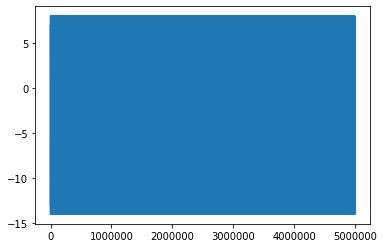

In [18]:
time = np.arange(0,5000000)
plt.plot(time, rewards_tracked[initial_state_Q])
plt.show()

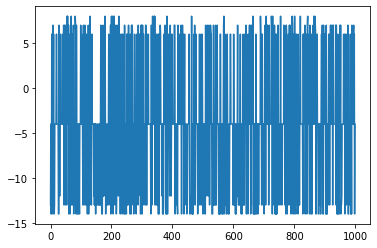

In [17]:
time = np.arange(0,1000)
plt.plot(time, rewards_tracked[initial_state_Q][0:1000])
plt.show()

We can clearly see that for the initial 1000 episodes the reward for initial state is varying a lot i.e. it is not saturated

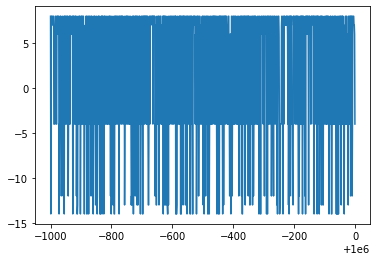

In [20]:
time = np.arange(999000,1000000)
plt.plot(time, rewards_tracked[initial_state_Q][999000:1000000])
plt.show()

The rewards for initial state for 1000 episodes after playing for 1 billion episodes is varying less compared to above graph however it is not at all saturated.

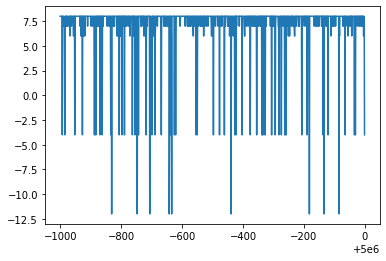

In [19]:
time = np.arange(4999000,5000000)
plt.plot(time, rewards_tracked[initial_state_Q][4999000:5000000])
plt.show()

We can clearly see that for the last 1000 episodes after running for approx 5 billion episodes the reward for initial state is saturated i.e. the reward is not varying much. This means that the Reinforcement Agent is learning the policy for winning. 

We can clearly see from the above graphs that the reward is varying less at the end of episode, 
however it is varying a lot at the start of episodes which indicates that it is converging

We can clearly see from above plot that State Value for a particular action is converging after some iterations/episodes

#### Check the Q-dictionary

In [21]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 3.3028074772840865,
              (0, 3): 3.78906903346125,
              (0, 5): 1.776533972214056,
              (0, 7): 3.1416015262716823,
              (0, 9): 3.867914570619894,
              (1, 1): 2.8110216209975545,
              (1, 3): 1.831366810234101,
              (1, 5): 5.505054117702631,
              (1, 7): 2.7939550513899496,
              (1, 9): 2.402745875172748,
              (2, 1): 4.099313918603016,
              (2, 3): 3.3198286197523506,
              (2, 5): 0.9470808792981276,
              (2, 7): 3.697750159209255,
              (2, 9): 3.8568008819137596,
              (3, 1): 2.0201341435241544,
              (3, 3): 3.059142744694035,
              (3, 5): 2.843892924294231,
              (3, 7): 2.9092640482433163,
              (3, 9): 3.845234749056998,
              (4, 1): 2.7614058626547493,
              (4, 3): 3.482148439981646,
              (4, 5): -0.45654334396307905,
      

In [22]:
# List of Tracked states 
for i in default_state:
    print('------------------')
    print('State:',i)
    print(Q_dict[i])
    

------------------
State: x-x-x-2-9-x-x-x-x
{(0, 1): -1.1211695110000002, (0, 3): -0.8499053647030009, (0, 5): -0.8499053647030009, (0, 7): -0.8649148282327008, (1, 1): -1.3813463647030009, (1, 3): -1.1234848754503899, (1, 5): 6.804855430832387, (1, 7): -1.162733750114816, (2, 1): -1.6603928455780927, (2, 3): -1.5882844967304135, (2, 5): -1.2141948746652071, (2, 7): -1.5689053647030007, (5, 1): -0.8332281830033343, (5, 3): -0.8477883197816389, (5, 5): -0.8332281830033343, (5, 7): -0.8362244361195795, (6, 1): -1.5555702844943344, (6, 3): -1.8622339061670998, (6, 5): -3.810912551406097, (6, 7): -2.5622281830033344, (7, 1): -1.0142366391835513, (7, 3): -2.372228183003334, (7, 5): -1.9032564140786379, (7, 7): -0.901522909781639, (8, 1): -0.9320909525189999, (8, 3): -1.0944918572670999, (8, 5): -1.1365960340273218, (8, 7): -0.9884595772048159}
------------------
State: x-x-x-5-x-4-x-x-x
{(0, 1): -1.7685061911148159, (0, 3): -1.5083159502418217, (0, 7): -1.2369329556830662, (0, 9): -1.129618

#### Check the states tracked for Q-values convergence

In [1]:
# code for plotting the graphs for state-action pairs tracked

State: x-x-x-2-9-x-x-x-x
Action: (1, 5)


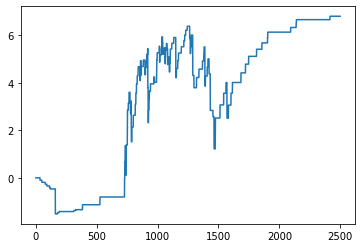

State: x-x-x-5-x-4-x-x-x
Action: (4, 1)


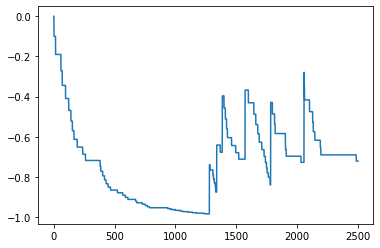

State: 6-x-x-x-x-7-x-x-x
Action: (7, 9)


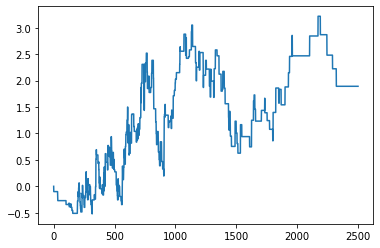

State: x-3-x-x-x-x-x-x-6
Action: (2, 9)


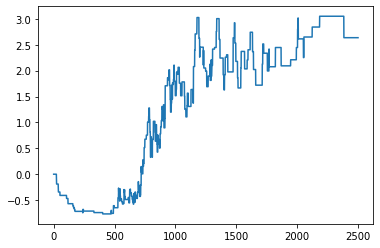

State: x-x-x-8-x-x-x-x-5
Action: (4, 9)


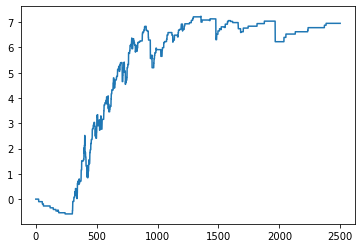

State: x-x-x-2-x-x-x-x-5
Action: (4, 3)


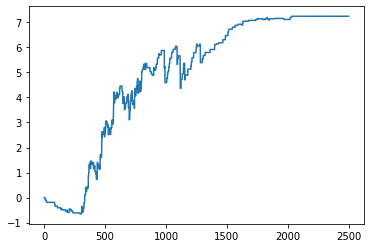

State: x-x-x-6-x-x-x-3-x
Action: (1, 5)


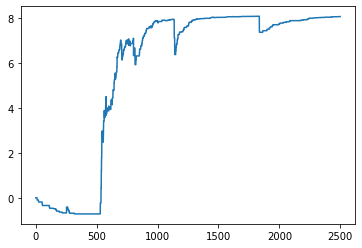

State: x-x-x-x-x-4-1-x-x
Action: (1, 5)


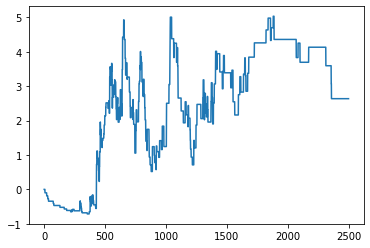

State: 5-8-x-x-x-x-x-x-x
Action: (8, 7)


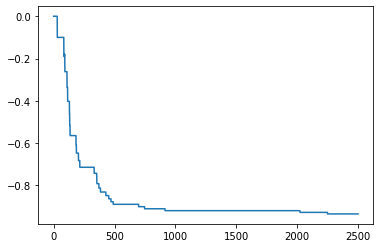

State: 2-x-x-x-x-x-9-x-x
Action: (3, 1)


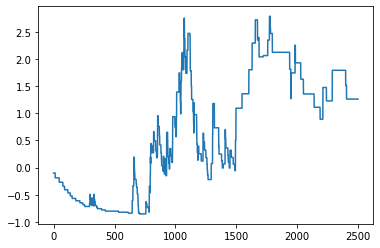

In [25]:
states_counter = 10 #No. of Tracked status to plot for State-Action pair for Convergence
if states_counter>len(States_track):
    states_counter = len(States_track)
for i in (States_track):
    action = max(Q_dict[i],key=Q_dict[i].get)
    x_axis = np.arange(len(States_track[i][action]))
    print('State:', i)
    print('Action:', action)
    plt.plot(x_axis, States_track[i][action])
    plt.show()
    states_counter = states_counter -1
    if states_counter<=0:
        break

We can clearly see that the State-Action Reward value is also saturating after executing more no. of episodes.
So for a given state S and action A, if action A is not good then the reward value is saturating towards the minimum value,
and for the scenario where action A is good for given state S then the reward is saturating towards the maximum value of reward.
This means that the agent is learning which action to take and which to avoid given a state S. 
This helps RL Agent to build the policy for winning

### Epsilon - decay check

In [26]:
import numpy as np
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

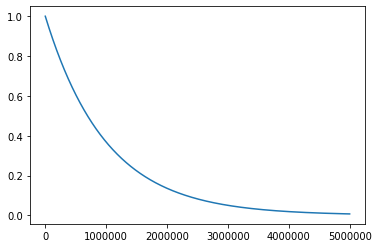

In [27]:
from matplotlib import pyplot as plt
plt.plot(time, epsilon)
plt.show()